In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes/diabetes.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [5]:
data = pd.read_csv("/kaggle/input/diabetes/diabetes.csv")

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [6]:
data.shape

(768, 9)

In [7]:
###Eksik Değer Kontrolü Yapalım.
data.isnull().sum()
data.isnull().sum().sum()

0

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
# cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(data)



Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

In [9]:
### Değişkenleri Ayır
cat_cols, num_cols, cat_but_car = grab_col_names(data)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [10]:
def cat_summary(dataframe, col_name, plot=False):
    print(f"\nSütun: {col_name}")
    print(pd.DataFrame({
        "Count": dataframe[col_name].value_counts(),
        "Ratio (%)": 100 * dataframe[col_name].value_counts(normalize=True)
    }))
    


In [11]:
# Örnek: Sadece 'Outcome' değişkeni kategoriktir
cat_cols = ["Outcome"]

# Fonksiyonu her bir kategorik değişkende uygula
for col in cat_cols:
    cat_summary(data, col)


Sütun: Outcome
         Count  Ratio (%)
Outcome                  
0          500     65.104
1          268     34.896


In [12]:
# Örnek: Sadece 'Outcome' değişkeni kategoriktir
num_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Fonksiyonu her bir kategorik değişkende uygula
for col in num_cols:
    cat_summary(data, col)




Sütun: Pregnancies
             Count  Ratio (%)
Pregnancies                  
1              135     17.578
0              111     14.453
2              103     13.411
3               75      9.766
4               68      8.854
5               57      7.422
6               50      6.510
7               45      5.859
8               38      4.948
9               28      3.646
10              24      3.125
11              11      1.432
13              10      1.302
12               9      1.172
14               2      0.260
15               1      0.130
17               1      0.130

Sütun: Glucose
         Count  Ratio (%)
Glucose                  
99          17      2.214
100         17      2.214
111         14      1.823
129         14      1.823
125         14      1.823
106         14      1.823
112         13      1.693
108         13      1.693
95          13      1.693
105         13      1.693
102         13      1.693
122         12      1.562
109         12      1.562
117 

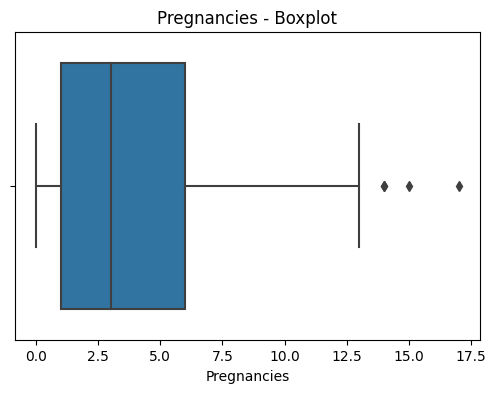

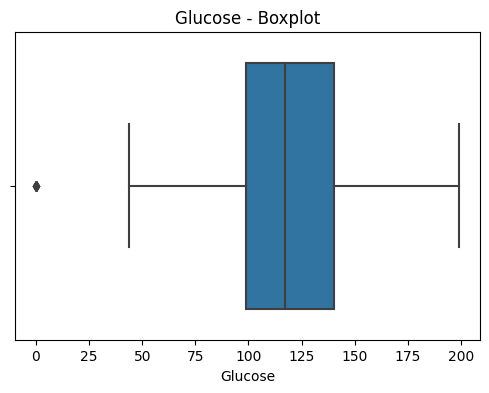

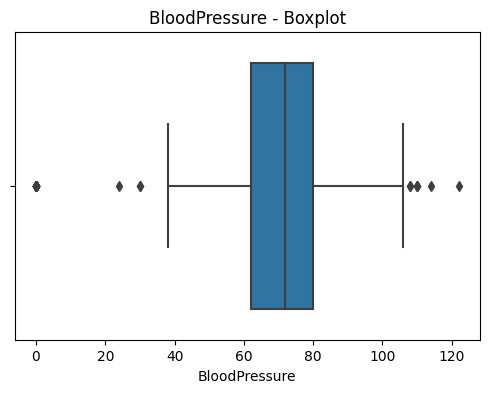

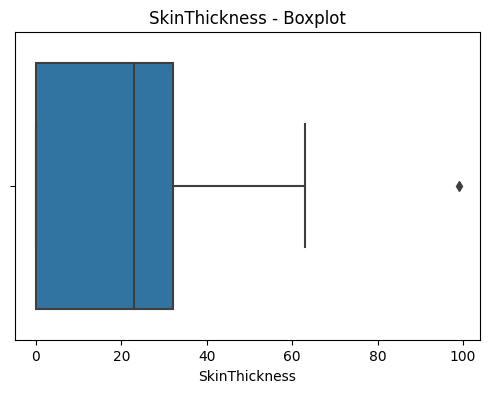

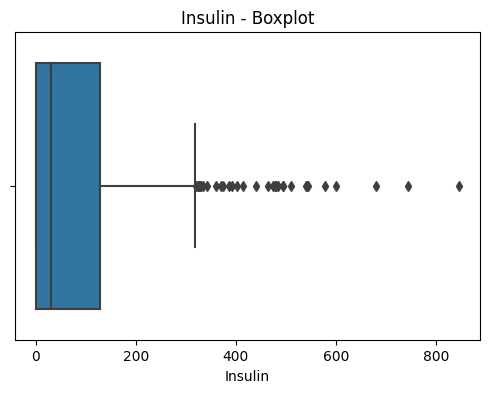

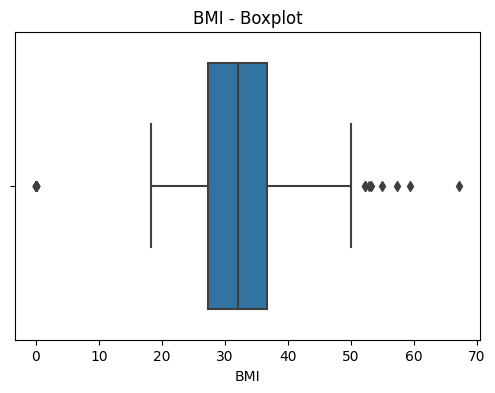

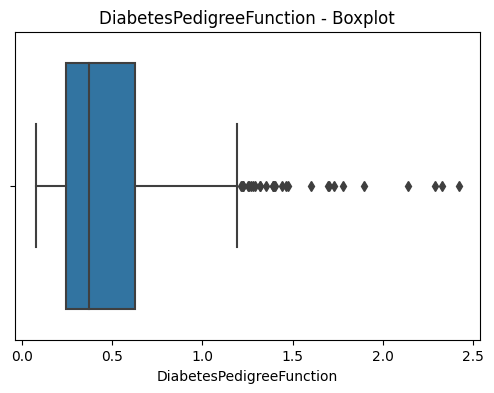

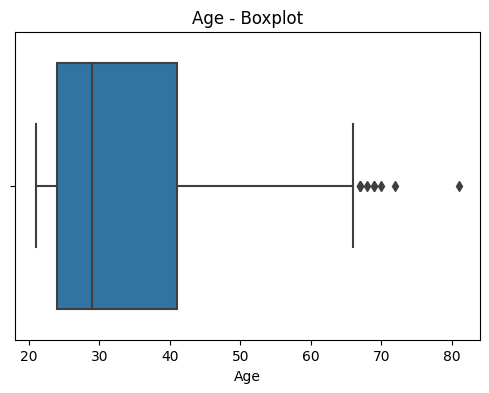

In [13]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[col])
    plt.title(f"{col} - Boxplot")
    plt.show()


In [14]:
data.groupby("Outcome")[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
 'Insulin', 'BMI', 'DiabetesPedigreeFunction','Age']].mean()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298,109.980,68.184,19.664,68.792,30.304,0.430,31.190
1,4.866,141.257,70.825,22.164,100.336,35.143,0.550,37.067


In [15]:
##Correlation

data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


In [16]:
data.corr()["Outcome"].sort_values(ascending=True)


BloodPressure              0.065
SkinThickness              0.075
Insulin                    0.131
DiabetesPedigreeFunction   0.174
Pregnancies                0.222
Age                        0.238
BMI                        0.293
Glucose                    0.467
Outcome                    1.000
Name: Outcome, dtype: float64

In [17]:
###Aykırı Gözlem Analizi

## Q1 - 1.5 * IQR’den küçükse  
## veya  
## Q3 + 1.5 * IQR’den büyükse → AYKIRI


Sadece sayısal değişkenlerde aykırı gözlemlere bakarım.
check_outliner() ile True dönenler aykırı kabul ederim.
Bunlarla baskılama,silme,dönüştürme yaparım.

In [18]:
def check_outlier(dataframe, col_name):
    q1 = dataframe[col_name].quantile(0.25)
    q3 = dataframe[col_name].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = dataframe[(dataframe[col_name] < lower) | (dataframe[col_name] > upper)]
    return outliers.shape[0] > 0  # True or False


In [19]:
for col in num_cols:
    print(f"{col}: {check_outlier(data, col)}")


Pregnancies: True
Glucose: True
BloodPressure: True
SkinThickness: True
Insulin: True
BMI: True
DiabetesPedigreeFunction: True
Age: True


In [20]:
# eksik gozlem var mı yok mu sorgusu
data.isnull().values.any()

# degiskenlerdeki eksik deger sayisi
data.isnull().sum()

# degiskenlerdeki tam deger sayisi
data.notnull().sum()

# veri setindeki toplam eksik deger sayisi
data.isnull().sum().sum()

# en az bir tane eksik degere sahip olan gözlem birimleri
data[data.isnull().any(axis=1)]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [21]:
# tam olan gözlem birimleri
data[data.notnull().all(axis=1)]

# Azalan şekilde sıralamak
data.isnull().sum().sort_values(ascending=False)

(data.isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)


Pregnancies                0.000
Glucose                    0.000
BloodPressure              0.000
SkinThickness              0.000
Insulin                    0.000
BMI                        0.000
DiabetesPedigreeFunction   0.000
Age                        0.000
Outcome                    0.000
dtype: float64

###Feature Engineering

##Adım 1:Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb. 
değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir.
Örneğin; bir kişinin glikoz veya insulin değeri 0 olamayacaktır. 
Bu durumu dikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik 
değerlere işlemleri uygulayabilirsiniz.

In [22]:
zero_columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

In [23]:
# Bu sütunlarda 0 değerlerini NaN ile değiştir
data[zero_columns] = data[zero_columns].replace(0, np.nan)
data[zero_columns].head()


,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148.000,72.000,35.000,NaN,33.600
1,85.000,66.000,29.000,NaN,26.600
2,183.000,64.000,NaN,NaN,23.300
3,89.000,66.000,23.000,94.000,28.100
4,137.000,40.000,35.000,168.000,43.100


In [24]:
# Eksik değerlerin sayısı ve oranı
missing_summary = data.isnull().sum().to_frame(name="Missing Count")
missing_summary["Missing Ratio (%)"] = 100 * missing_summary["Missing Count"] / len(data)
missing_summary[missing_summary["Missing Count"] > 0]


,Missing Count,Missing Ratio (%)
Glucose,5,0.651
BloodPressure,35,4.557
SkinThickness,227,29.557
Insulin,374,48.698
BMI,11,1.432


In [25]:
def bmi_category(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obese"

data["BMI_Category"] = data["BMI"].apply(bmi_category)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1,Obese
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0,Overweight
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1,Normal
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Overweight
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Obese


In [26]:
def glucose_class(g):
    if g < 70:
        return "Low"
    elif 70 <= g < 100:
        return "Normal"
    elif 100 <= g < 126:
        return "Prediabetes"
    else:
        return "Diabetes"

data["Glucose_Class"] = data["Glucose"].apply(glucose_class)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Glucose_Class
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1,Obese,Diabetes
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0,Overweight,Normal
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1,Normal,Diabetes
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Overweight,Normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Obese,Diabetes


In [27]:
 ### Encoding işlemlerini gerçekleştiriniz.

binary_cols = [col for col in data.columns if data[col].dtype not in [int, float]
               and data[col].nunique() == 2]

for col in binary_cols:
    data = label_encoder(data, col)
print(binary_cols)

[]


Veri setinde ikili kategorik sütun yok demektir

In [28]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(f"\nDeğişken: {col}")
        print(pd.DataFrame({
            "Count": dataframe[col].value_counts(),
            "Ratio": dataframe[col].value_counts() / len(dataframe),
            "Target_Mean": data.groupby(col)[target].mean()
        }))


In [29]:
rare_analyser(data, "Outcome", cat_cols)



Değişken: Outcome
         Count  Ratio  Target_Mean
Outcome                           
0          500  0.651        0.000
1          268  0.349        1.000


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Standartlaştırmak istediğimiz sayısal sütunlar
num_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

data[num_cols] = scaler.fit_transform(data[num_cols])

print(data[num_cols].head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age
0        0.640    0.862         -0.033          0.559      NaN  0.165                     0.468  1.426
1       -0.845   -1.202         -0.518         -0.015      NaN -0.846                    -0.365 -0.191
2        1.234    2.009         -0.679            NaN      NaN -1.323                     0.604 -0.106
3       -0.845   -1.071         -0.518         -0.588   -0.519 -0.630                    -0.921 -1.042
4       -1.142    0.502         -2.619          0.559    0.105  1.538                     5.485 -0.020


In [31]:
print(data["BMI_Category"].value_counts())
print(data["Glucose_Class"].value_counts())


BMI_Category
Obese          483
Overweight     179
Normal         102
Underweight      4
Name: count, dtype: int64
Glucose_Class
Diabetes       302
Prediabetes    274
Normal         181
Low             11
Name: count, dtype: int64


In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["BMI_Category"] = pd.DataFrame(le.fit_transform(data["BMI_Category"]))
data["Glucose_Class"] = pd.DataFrame(le.fit_transform(data["Glucose_Class"]))
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Glucose_Class
0,0.640,0.862,-0.033,0.559,NaN,0.165,0.468,1.426,1,1,0
1,-0.845,-1.202,-0.518,-0.015,NaN,-0.846,-0.365,-0.191,0,2,2
2,1.234,2.009,-0.679,NaN,NaN,-1.323,0.604,-0.106,1,0,0
3,-0.845,-1.071,-0.518,-0.588,-0.519,-0.630,-0.921,-1.042,0,2,2
4,-1.142,0.502,-2.619,0.559,0.105,1.538,5.485,-0.020,1,1,0


In [33]:
data= data.fillna(data.median())
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Glucose_Class
0,0.640,0.862,-0.033,0.559,-0.258,0.165,0.468,1.426,1,1,0
1,-0.845,-1.202,-0.518,-0.015,-0.258,-0.846,-0.365,-0.191,0,2,2
2,1.234,2.009,-0.679,-0.015,-0.258,-1.323,0.604,-0.106,1,0,0
3,-0.845,-1.071,-0.518,-0.588,-0.519,-0.630,-0.921,-1.042,0,2,2
4,-1.142,0.502,-2.619,0.559,0.105,1.538,5.485,-0.020,1,1,0


In [34]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [36]:
# Bağımlı ve bağımsız değişkenleri ayır
y = data["Outcome"]
X = data.drop(["Outcome"], axis=1)

# Eğitim ve test verisi
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=17
)

In [37]:
# Model kur ve eğit
rf_model = RandomForestClassifier(random_state=46)
rf_model.fit(X_train, y_train)

# Tahmin yap
y_pred = rf_model.predict(X_test)

# Başarı ölç
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7922077922077922


In [38]:
print(data.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
BMI_Category                0
Glucose_Class               0
dtype: int64


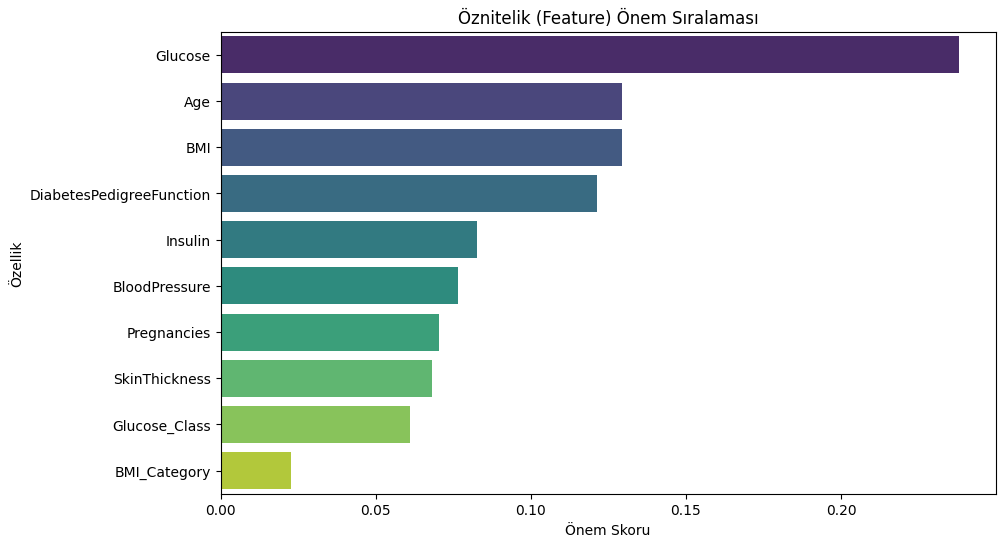

In [39]:
importances = rf_model.feature_importances_
features = X.columns

# Önem sırasına göre sırala
feature_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Görselleştir
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_df, palette="viridis")
plt.title("Öznitelik (Feature) Önem Sıralaması")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellik")
plt.show()
